In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [45]:
df_enc = pd.read_csv("data/enc/data-enc-2024-04-15.csv")

In [46]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84131 entries, 0 to 84130
Data columns (total 86 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   avg_price_5                       84131 non-null  float64
 1   bathrooms_total                   84131 non-null  float64
 2   bedrooms_extra                    84131 non-null  float64
 3   bedrooms                          84131 non-null  float64
 4   stories_total                     84131 non-null  float64
 5   size_interior                     84131 non-null  float64
 6   lng                               84131 non-null  float64
 7   lat                               84131 non-null  float64
 8   parkings                          84131 non-null  float64
 9   price                             84131 non-null  float64
 10  household_income                  84131 non-null  float64
 11  individual_income                 84131 non-null  float64
 12  comm

In [4]:
df_ON = df_enc[df_enc["province_Ontario"] == True]
df_QC = df_enc[df_enc["province_Quebec"] == True]
df_BC = df_enc[df_enc["province_British Columbia"] == True]
df_AB = df_enc[df_enc["province_Alberta"] == True]
df_SK = df_enc[df_enc["province_Saskatchewan"] == True]
df_MB = df_enc[df_enc["province_Manitoba"] == True]
# East
df_ES = df_enc[(df_enc["province_Nova Scotia"] == True) |
               (df_enc["province_New Brunswick"] == True) |
               (df_enc["province_Newfoundland & Labrador"] == True) |
               (df_enc["province_Prince Edward Island"] == True)]
# North
df_NO = df_enc[(df_enc["province_Yukon"] == True) |
               (df_enc["province_Northwest Territories"] == True)]

df_ON = df_ON.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_QC = df_QC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_BC = df_BC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_AB = df_AB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_SK = df_SK.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_MB = df_MB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_ES = df_ES.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan","province_Manitoba", "province_Yukon", "province_Northwest Territories"], axis=1)
df_NO = df_NO.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan", "province_Manitoba", "province_Nova Scotia", "province_New Brunswick",
                    "province_Newfoundland & Labrador", "province_Prince Edward Island"], axis=1)

In [5]:
df_QC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7130 entries, 18514 to 81980
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avg_price_5                    7130 non-null   float64
 1   bathrooms_total                7130 non-null   float64
 2   bedrooms_extra                 7130 non-null   float64
 3   bedrooms                       7130 non-null   float64
 4   stories_total                  7130 non-null   float64
 5   size_interior                  7130 non-null   float64
 6   lng                            7130 non-null   float64
 7   lat                            7130 non-null   float64
 8   parkings                       7130 non-null   float64
 9   price                          7130 non-null   float64
 10  household_income               7130 non-null   float64
 11  individual_income              7130 non-null   float64
 12  commute_transit                7130 non-null   f

In [6]:
df_ON.corr(numeric_only=True)["price"].sort_values(ascending=False).head(20)

price                           1.000000
avg_price_5                     0.670251
size_interior                   0.534272
bathrooms_total                 0.513976
individual_income               0.458461
household_income                0.458461
bedrooms                        0.369380
parkings                        0.344734
building_type_House             0.271583
single_family                   0.259185
edu_bachelor_degree             0.253977
ownership_type_group_ids_1.0    0.242900
edu_university_certificate      0.235052
stories_total                   0.224869
edu_post_graduate_degree        0.213194
owners                          0.204849
bedrooms_extra                  0.204777
age_15_to_19                    0.169346
multi_family                    0.156949
area_single_detached            0.154393
Name: price, dtype: float64

## Raw Input

In [7]:
kf = KFold(n_splits=10)

In [8]:
cb1 = CatBoostRegressor(silent=True)

X = df_ON.drop("price", axis=1)
y = df_ON["price"]

scores1 = cross_val_score(cb1, X, y, cv=kf, scoring="r2")

print(f"\n{scores1}\n")
pd.Series(scores1).describe()


[0.55455993 0.70252857 0.74657481 0.69995128 0.54472178 0.53689561
 0.68660901 0.69894647 0.64957889 0.69298016]



count    10.000000
mean      0.651335
std       0.076834
min       0.536896
25%       0.578315
50%       0.689795
75%       0.699700
max       0.746575
dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cb1.fit(X_train, y_train)
y_pred = cb1.predict(X_test)

In [10]:
r2_score(y_test, y_pred)

0.6588271160988745

In [11]:
root_mean_squared_error(y_test, y_pred)

331846.0037040613

In [12]:
y_df1 = pd.DataFrame({"y_test":y_test.values, "y_pred":y_pred})

In [13]:
np.round(y_df1.head(20))

,y_test,y_pred
0,1249900.0,1572071.0
1,1149900.0,1152422.0
2,849000.0,935158.0
3,899900.0,1105390.0
4,975000.0,853042.0
5,749999.0,874600.0
6,849900.0,725088.0
7,979900.0,1172047.0
8,559900.0,618783.0
9,560000.0,665670.0


## Scaled

In [14]:
cb2 = CatBoostRegressor(silent=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores2 = cross_val_score(cb2, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores2}\n")
pd.Series(scores2).describe()


[0.555534   0.70244844 0.74618522 0.69515754 0.53469257 0.53392035
 0.67565578 0.70157918 0.64726726 0.69005829]



count    10.000000
mean      0.648250
std       0.077914
min       0.533920
25%       0.578467
50%       0.682857
75%       0.699974
max       0.746185
dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb2.fit(X_train, y_train)
y_pred = cb2.predict(X_test)

In [16]:
r2_score(y_test, y_pred)

0.6588954119983284

In [17]:
root_mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred.reshape(-1,1)))

331812.7876181843

In [18]:
y_df2 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [19]:
np.round(y_df2.head(20))

,y_test,y_pred
0,1249900.0,1548781.0
1,1149900.0,1185296.0
2,849000.0,922414.0
3,899900.0,1107077.0
4,975000.0,867614.0
5,749999.0,850348.0
6,849900.0,717587.0
7,979900.0,1007620.0
8,559900.0,617147.0
9,560000.0,666155.0


## log1p: X Only

In [20]:
from scipy import stats

sub_df = df_AB.copy(deep=True)

skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_Before"] = sub_df.corr()["price"].values
skew_df["Skew_Before"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_Before"] = skew_df["Skew_Before"].apply(abs)
skew_df["Skewed_Before"] = skew_df["AbsSkew_Before"].apply(lambda x: True if x>= 0.5 else False)

# before_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

for column in skew_df.query("Skewed_Before == True")["Feature"].values:
    if column != "price":
        sub_df[column] = np.log1p(sub_df[column])


# skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_After"] = sub_df.corr()["price"].values
skew_df["Skew_After"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_After"] = skew_df["Skew_After"].apply(abs)
skew_df["Skewed_After"] = skew_df["AbsSkew_After"].apply(lambda x: True if x>= 0.5 else False)

# after_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

# log_columns = list(before_log - after_log - {"price", "lng", "lat"})
log_columns = skew_df[(skew_df["Skewed_Before"]==True) & (skew_df["Corr_Price_After"] > skew_df["Corr_Price_Before"])]["Feature"].values

log_columns

/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(['bedrooms_extra', 'commute_transit', 'commute_drive',
       'age_65_to_79', 'age_80_plus', 'lang_en_only', 'lang_en_and_fr',
       'area_apt_5_plus_floors', 'loc_transit_friendly', 'loc_wellness',
       'building_type_House', 'ownership_type_group_ids_0.0',
       'ownership_type_group_ids_1.0'], dtype=object)

In [21]:
cb3 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores3 = cross_val_score(cb3, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores3}\n")
pd.Series(scores3).describe()


[0.555534   0.70244844 0.74618522 0.69515754 0.53469257 0.53392042
 0.67565578 0.70157918 0.64726726 0.69005827]



count    10.000000
mean      0.648250
std       0.077914
min       0.533920
25%       0.578467
50%       0.682857
75%       0.699974
max       0.746185
dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb3.fit(X_train, y_train)
y_pred = cb3.predict(X_test)

In [23]:
r2_score(y_test, y_pred)

0.6588954119983284

In [24]:
root_mean_squared_error(y_test, y_pred)

0.5949390850624308

In [25]:
y_df3 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [26]:
np.round(y_df3.head(20))

,y_test,y_pred
0,1249900.0,1548781.0
1,1149900.0,1185296.0
2,849000.0,922414.0
3,899900.0,1107077.0
4,975000.0,867614.0
5,749999.0,850348.0
6,849900.0,717587.0
7,979900.0,1007620.0
8,559900.0,617147.0
9,560000.0,666155.0


# log1p: X and y

In [27]:
cb4 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

y_log = np.log1p(y)

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y_log.to_numpy().reshape(-1,1))

scores4 = cross_val_score(cb4, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores4}\n")
pd.Series(scores4).describe()


[0.71466767 0.81415407 0.86861021 0.75054562 0.69929178 0.69806087
 0.72502899 0.79790738 0.79162327 0.79968077]



count    10.000000
mean      0.765957
std       0.057033
min       0.698061
25%       0.717258
50%       0.771084
75%       0.799237
max       0.868610
dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb4.fit(X_train, y_train)
y_pred = cb4.predict(X_test)

In [29]:
r2_score(y_test, y_pred)

0.8004142700090946

### Reverse Log

In [30]:
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.21397397409612529

In [31]:
root_mean_squared_error(y_test, y_pred)

0.44233711321753044

In [32]:
y_df4 = pd.DataFrame({"y_test":np.expm1(scaler_y.inverse_transform(y_test))[:,0].tolist(),
                      "y_pred":np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist())})

In [33]:
np.round(y_df4.head(20))

,y_test,y_pred
0,1249900.0,1472999.0
1,1149900.0,1170708.0
2,849000.0,943827.0
3,899900.0,1009733.0
4,975000.0,886280.0
5,749999.0,784351.0
6,849900.0,717121.0
7,979900.0,1131787.0
8,559900.0,613372.0
9,560000.0,650601.0


In [34]:
np.round(y_df3.head(20))

,y_test,y_pred
0,1249900.0,1548781.0
1,1149900.0,1185296.0
2,849000.0,922414.0
3,899900.0,1107077.0
4,975000.0,867614.0
5,749999.0,850348.0
6,849900.0,717587.0
7,979900.0,1007620.0
8,559900.0,617147.0
9,560000.0,666155.0


/tmp/ipykernel_5966/305300287.py:2: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
/tmp/ipykernel_5966/305300287.py:3: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))


/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/matplotlib/ticker.py:2096: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


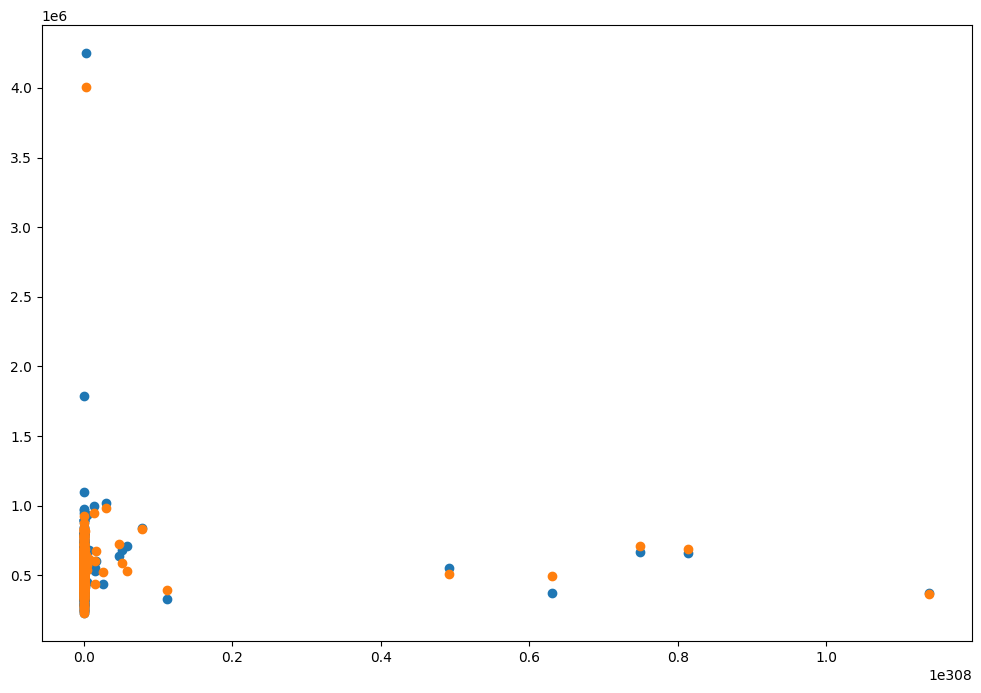

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

In [36]:
r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

0.6530870562579423

In [37]:
X_log

,avg_price_5,bathrooms_total,bedrooms_extra,bedrooms,stories_total,size_interior,lng,lat,parkings,household_income,...,loc_cafes,loc_quiet,loc_parks,building_type_Apartment,building_type_House,building_type_Row / Townhouse,building_type_Semi-Detached,ownership_type_group_ids_0.0,ownership_type_group_ids_1.0,ownership_type_group_ids_2.0
0,575900.0,3.0,0.000000,4.0,2.5,2810.000000,-83.010728,42.321421,0.0,138252.29470,...,3.0,5.0,3.5,0.0,0.693147,0.0,0.0,0.000000,0.693147,0.0
1,674900.0,2.0,0.000000,2.0,1.0,1072.000000,-83.029633,42.265783,0.0,125972.08190,...,1.5,4.5,3.5,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.0
2,1009739.8,3.0,0.000000,4.0,2.0,1965.881818,-83.087577,42.228649,0.0,205459.75390,...,1.0,5.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.693147,0.0
3,349180.0,1.0,0.000000,4.0,1.0,1040.426146,-83.056441,42.304613,0.0,76724.51700,...,2.5,3.0,3.5,0.0,0.693147,0.0,0.0,0.000000,0.693147,0.0
4,319360.0,1.0,0.000000,3.0,1.0,3718.455676,-83.055635,42.302468,0.0,78194.19500,...,2.0,4.0,3.5,0.0,0.693147,0.0,0.0,0.000000,0.693147,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79634,351900.0,3.0,0.000000,2.0,1.0,1028.000000,-89.249558,48.421573,0.0,76593.21250,...,2.0,5.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.0
79635,376960.0,1.0,0.000000,2.0,1.0,1150.000000,-89.186733,48.457044,0.0,91878.46140,...,1.0,2.5,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.0
79636,419540.0,2.0,1.098612,3.0,1.0,2080.000000,-84.551927,48.348100,6.0,76208.84630,...,0.0,5.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.693147,0.0
79637,554940.0,2.0,0.000000,4.0,2.0,1017.294315,-80.033059,48.151002,0.0,106107.75410,...,2.5,4.0,0.0,0.0,0.000000,0.0,1.0,0.693147,0.000000,0.0


In [38]:
y

0        849900.0
1        399900.0
2        959900.0
3        299900.0
4        399000.0
           ...   
79634    319900.0
79635    359900.0
79636    350000.0
79637    379000.0
82957    279900.0
Name: price, Length: 36631, dtype: float64

In [39]:
df_log = X_log.copy(deep=True)
df_log["price_log"] = np.log1p(y)

In [40]:
df_log.corr(numeric_only=True)["price_log"].sort_values(ascending=False).head(20)

price_log                       1.000000
avg_price_5                     0.692617
bathrooms_total                 0.608634
size_interior                   0.586623
household_income                0.467156
individual_income               0.467156
bedrooms                        0.448752
parkings                        0.414089
single_family                   0.357484
building_type_House             0.335289
ownership_type_group_ids_1.0    0.319951
edu_bachelor_degree             0.287832
owners                          0.285195
stories_total                   0.271381
edu_university_certificate      0.263555
bedrooms_extra                  0.257995
multi_family                    0.224168
edu_post_graduate_degree        0.223964
age_15_to_19                    0.211755
area_single_detached            0.196009
Name: price_log, dtype: float64